# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.5 MB/s eta 0:00:00


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
# Import models you're considering
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from sklearn.model_selection import GridSearchCV


/var/folders/g3/9v4gs6r57_7_bc8nsrqdz_t40000gn/T/ipykernel_57214/480258712.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Model Selection


We consider a neural network or an LSTM (those were used in the models in the literature review)



## Feature Engineering

Three feature engeneering steps were performed: Instead of using the max und min temperature, the span of temperature of that day was used. --> Tells if the weather was stable or fluctuating that day

The interaction between the average Temperature and the humidity is used -->There is a correlation between these two parameters


The pressure change is also interesting, a decreasing pressure indicates a low pressure area, an increasing pressure indicates a high pressure area


In [2]:
df = pd.read_csv(
    '../Dobersdorf/Dobersdorf_all_cut_final.csv',
    nrows=5
)

print(df)

   Tag  Monat  Jahr Produktion(kWH)         Tavg  Tmin  Tmax          Hum  \
0   16      7  2023           55,79  18,22083333  15,8  22,1  74,91666667   
1   17      7  2023           54,63  16,38333333  12,4  19,4        78,75   
2   18      7  2023           65,68  16,70416667  11,8  21,6  73,54166667   
3   19      7  2023           28,26      14,7125  12,7  17,2       85,625   
4   20      7  2023           58,93  14,91666667  10,7  19,4         76,5   

           VPD Prec  Pbin         Wspd Wmax         Wdir          Cld   Sol  \
0   0,56164731  0,8     1  4,445833333    7  219,5186547        6,125  1991   
1  0,424523113    7     1  3,929166667    6  236,8576391  6,041666667  2102   
2  0,577180231    0     1  2,941666667  5,3    253,92248  5,416666667  2578   
3  0,247361166  2,9     1  1,820833333  2,9  244,7083359  7,291666667  1121   
4  0,447117605  0,3     1        3,625  6,1  268,2167486  3,708333333  2456   

    Sun         Pres          Vis  Soil  
0   7,7  1004,179167

In [2]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('../Dobersdorf/Dobersdorf_all_cut_final.csv', sep=",",  header=0)
print(df.columns.tolist())
print(df.dtypes)

####the floats are not recognized as floats
for col in df.columns:
    if df[col].dtype == object:
        df[col] = (
            df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')
        )
print(df.dtypes)
# Perform any feature engineering steps
# Example: df['new_feature'] = df['feature1'] + df['feature2']
df['temp_range'] = df['Tmax'] - df['Tmin']
df['temp_hum_interaction'] = df['Tavg'] * df['Hum']
##.diff() calculates the difference to the value the day before
df['pressure_change'] = df['Pres'].diff()

# Feature and target variable selection
X = df[['Tavg', 'temp_range','temp_hum_interaction','Sun','Pres','pressure_change','Vis', 'Tmin']]
y = df['Produktion(kWH)']
###values between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = np.array(y).reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

print (int(len(df))*0.7)
print (int(len(df))*0.15)
print (int(len(df)))


split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Split the dataset
##Splitting time series data random is problematic
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(X_train)
print(y_train)

###here we had to exclude missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

###here we had to exclude missing values
X_test= np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

['Tag', 'Monat', 'Jahr', 'Produktion(kWH)', 'Tavg', 'Tmin', 'Tmax', 'Hum', 'VPD', 'Prec', 'Pbin', 'Wspd', 'Wmax', 'Wdir', 'Cld', 'Sol', 'Sun', 'Pres', 'Vis', 'Soil']
Tag                 int64
Monat               int64
Jahr                int64
Produktion(kWH)    object
Tavg               object
Tmin               object
Tmax               object
Hum                object
VPD                object
Prec               object
Pbin                int64
Wspd               object
Wmax               object
Wdir               object
Cld                object
Sol                object
Sun                object
Pres               object
Vis                object
Soil               object
dtype: object
Tag                  int64
Monat                int64
Jahr                 int64
Produktion(kWH)    float64
Tavg               float64
Tmin               float64
Tmax               float64
Hum                float64
VPD                float64
Prec               float64
Pbin                 int64
Wsp

/var/folders/g3/9v4gs6r57_7_bc8nsrqdz_t40000gn/T/ipykernel_57214/2210638154.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
!pip install scikeras
!pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
def dimension_train(X, y, time_step=1):
      X1, y1 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X1.append(X[i:i+time_step,:])
        y1.append(y[i+time_step])
      return np.array(X1), np.array(y1)

time_step = 10
X,y=dimension_train(X_train,y_train, time_step)

print(len(X))
print(len(y))


722
722


In [28]:
# Implement hyperparameter tuning

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
time_step = 10
def model1(units=40,learning_rate=0.1):
  model1 = Sequential()
  model1.add(Input(shape=(time_step, 8)))
  model1.add(LSTM(units, return_sequences=True))
  model1.add(LSTM(units))
  model1.add(Dense(1))
  model1.compile(optimizer = keras.optimizers.Adam( learning_rate=learning_rate), loss='mean_squared_error')
  return model1

model = KerasRegressor(
    model=model1,
    verbose=0
)

param_grid = {
    "model__units": [50,60],
    "batch_size": [8,16],
    "epochs": [50,60],
    "model__learning_rate": [0.0001, 0.00001]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)



,estimator,KerasRegresso...se epochs=1 )
,param_grid,"{'batch_size': [8, 16], 'epochs': [50, 60], 'model__learning_rate': [0.0001, 1e-05], 'model__units': [50, 60]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function mod...t 0x1510c5120>


In [30]:
print(grid_search.best_params_)

{'batch_size': 8, 'epochs': 60, 'model__learning_rate': 0.0001, 'model__units': 50}


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [23]:


# Build the LSTM model(with hyperparameters)
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(time_step, 8))) #60
model.add(LSTM(60))
model.add(Dense(1))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error') #0.00001

# Train the model
result=model.fit(X, y, epochs=60, batch_size=16,validation_split=0.15) #60



Epoch 1/60


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0707 - val_loss: 0.0982
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0446 - val_loss: 0.1080
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0386 - val_loss: 0.0850
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0348 - val_loss: 0.0768
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0326 - val_loss: 0.0838
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321 - val_loss: 0.0750
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0313 - val_loss: 0.0777
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0314 - val_loss: 0.0785
Epoch 9/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0315 - val_loss: 0.0689
Epoch 10/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - val_loss: 0.0654
Epoch 11/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310 - val_loss: 0.0640
Epoch 12/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310 - val_loss: 0.0728

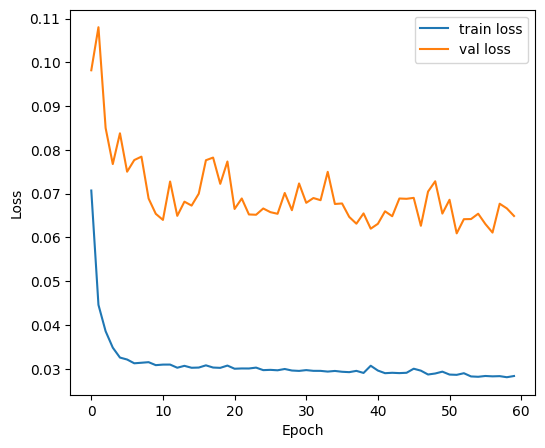

In [24]:
plt.figure(figsize=(6,5))

plt.plot(result.history["loss"], label="train loss")
plt.plot(result.history["val_loss"], label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('Dobersdorf_LSTM_loss_lr0.0001.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
print(len(X_test))
print(len(y_test))
###For the test sets
def dimension_test(X, y, time_step=1):
      X2, y2 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X2.append(X[i:i+time_step,:])
        y2.append(y[i + time_step - 1])
      return np.array(X2), np.array(y2)

time_step = 10
X_test1,y_test1=dimension_test(X_test,y_test, time_step)
print(len(X_test1))
print(len(y_test1))


183
183
173
173


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [26]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
y_pred = model.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred)
print("Mean squared error is:",mse)
mae= mean_absolute_error(y_test1, y_pred)
print("Mean absolute error is:",mae)

final=mae/np.max(y_test1)*100
print(final)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean squared error is: 0.018119128063058404
Mean absolute error is: 0.10413288017355335
12.618337961581247


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [27]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
##Comparing the Mse
##replace with new value
baseline_mse= 0.01206
print(f"Baseline Model mse: {baseline_mse}, New Model Accuracy: {mse:.4}")
print(f"The percentage error is: {final:.4} %")


Baseline Model mse: 0.01206, New Model Accuracy: 0.01812
The percentage error is: 12.62 %


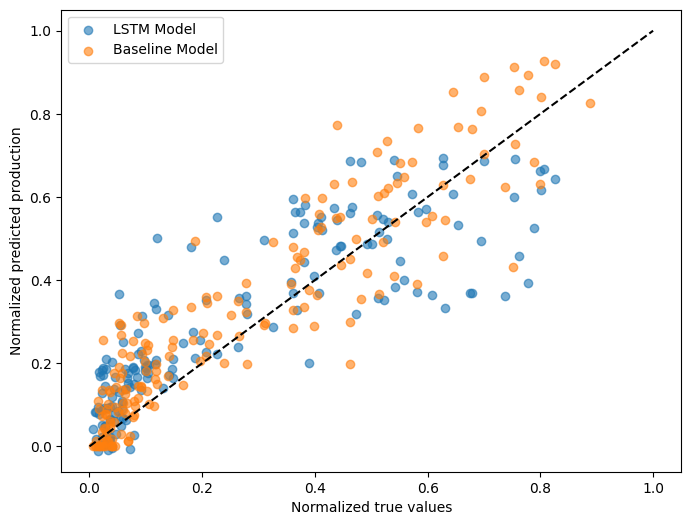

In [28]:
DB=np.load('Dobersdorf_baseline_true_vs_predicted.npy')

##elmshorn
plt.figure(figsize=(8,6))
#plt.scatter(y_test1, y_pred)
plt.scatter(y_test1, y_pred, label='LSTM Model', alpha=0.6)
plt.scatter(DB[0], DB[1], label='Baseline Model', alpha=0.6)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('Normalized true values')
plt.ylabel('Normalized predicted production')
plt.legend()
#np.save('Dobersdorf_LSTM_true_vs_predicted_lr0.0001.npy', np.array([y_test1, y_pred]))
#plt.savefig('Dobersdorf_LSTM_true_vs_predicted_only.png', dpi=300)
#plt.savefig('Dobersdorf_LSTM_vs_baseline_true_vs_predicted.png', dpi=300)
plt.show()